Basic analyses of behavior in the FHT task. 

In [2]:
import sys
import os
sys.path.append('/Users/angelaradulescu/Dropbox/research/thesis/code/analysis/libraries')
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 1. Load and prep behavioral data

In [98]:
behav_path = os.getcwd() + '/ProcessedData/AllData.csv' # this expects ProcessedData to be in the analysis repo
behav_data = pd.read_csv(behav_path)
subjects = behav_data['Subj'].unique()

## Get metadata.
n_trials = max(behav_data['Trial'])
n_games = max(behav_data['Game'])
game_length = len(behav_data.loc[(behav_data['Subj'] == 23) & (behav_data['Game'] == 1)])

# change subj to int
behav_data['Subj'] = behav_data['Subj'].astype(int)

## Add trial-within-game variable.
behav_data['WithinGameTrial'] = behav_data['Trial'] - (behav_data['Game']-1)*game_length
behav_data

,Subj,Trial,Game,Stim11,Stim12,Stim13,Stim21,Stim22,Stim23,Stim31,...,Outcome,Dim,Feat,CenterDim,CenterFeat,Correct,LearnedFeat,PoL,RT,WithinGameTrial
0,23,1,1,1,6,8,2,5,7,3,...,1.0,1,2,NaN,NaN,1.0,NaN,NaN,1.12700,1
1,23,2,1,2,5,7,1,4,8,3,...,1.0,1,2,NaN,NaN,1.0,NaN,NaN,1.08580,2
2,23,3,1,3,4,7,2,5,9,1,...,0.0,1,2,NaN,NaN,0.0,NaN,NaN,1.24420,3
3,23,4,1,1,4,7,2,5,8,3,...,0.0,1,2,NaN,NaN,1.0,NaN,NaN,0.47509,4
4,23,5,1,1,6,8,2,4,7,3,...,1.0,1,2,NaN,NaN,1.0,NaN,NaN,0.88090,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15195,71,396,20,1,5,7,3,4,9,2,...,1.0,1,2,NaN,NaN,1.0,NaN,NaN,0.61252,16
15196,71,397,20,1,5,8,2,4,9,3,...,1.0,1,2,NaN,NaN,1.0,NaN,NaN,0.89898,17
15197,71,398,20,1,6,7,2,4,9,3,...,1.0,1,2,NaN,NaN,1.0,NaN,NaN,0.59331,18
15198,71,399,20,1,6,7,3,5,8,2,...,1.0,1,2,NaN,NaN,1.0,NaN,NaN,0.52019,19


# 2. Plot general learning and accuracy

## 2a. Plot general learning curve

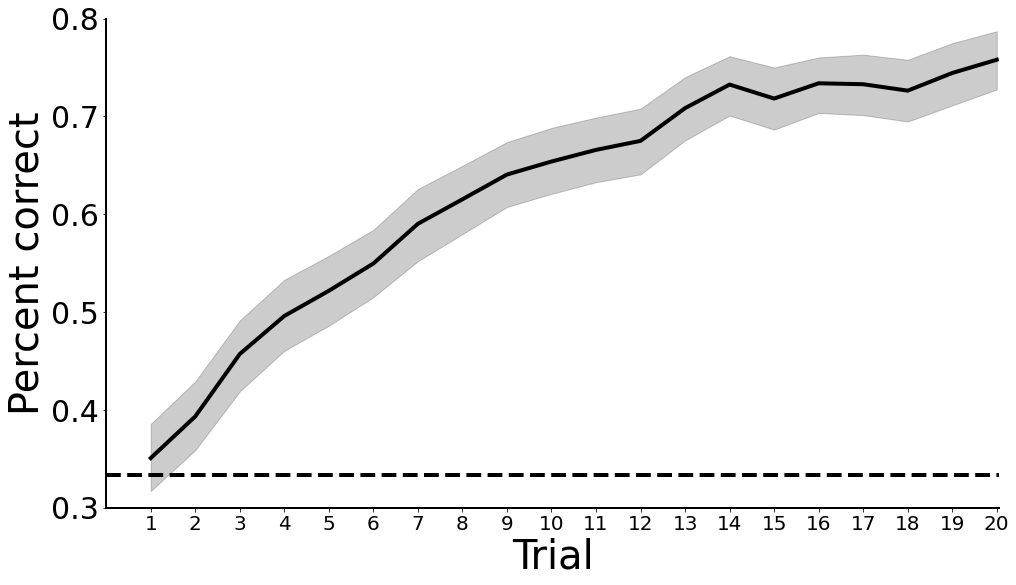

In [13]:
df = pd.melt(behav_data, col_level=0, id_vars='WithinGameTrial', value_vars=['Correct'])

fig, ax = plt.subplots(figsize=(16,9))
ax.axhline(y=1/3, color='k', lw=4, linestyle='--');
sns.lineplot(x = 'WithinGameTrial', y="value", err_style="band", ci=95, data=df, lw=4, legend=False, color='black')
sns.despine()
ax.set_xlim([0,game_length+.05])
ax.set_ylim([0.3,0.8])
ax.set_xticks(np.arange(game_length)+1)
xl = ax.set_xlabel('Trial',fontsize = 40);
yl = ax.set_ylabel('Percent correct',fontsize = 40);
for axis in ['top','bottom','left','right']:
      ax.spines[axis].set_linewidth(2)
ax.tick_params(axis='x',colors='k')
plt.xticks(fontsize=20);
plt.yticks(fontsize=30);

## 2b. Plot general number correct in last 6

In [114]:
def getLastSixGames(behav_data, game_length):
    last_6 = np.arange(game_length-6,game_length)+1

    df_last_6 = behav_data.loc[behav_data['WithinGameTrial'].isin(last_6)]
    df_last_6 = df_last_6.reset_index(drop=True)
    df_last_6 = df_last_6[['Subj','Game','WithinGameTrial','Correct']]

    ## Sum corrects in last 6 within game.
    df_last_6 = df_last_6.groupby(['Subj','Game'])['Correct'].sum().reset_index()

    ## Count and normalize by number of games.
    df_last_6 = df_last_6.groupby(['Subj','Correct']).count().unstack(fill_value=0).stack().reset_index()
    df_last_6['Game'] = df_last_6['Game'] / n_games
    return df_last_6


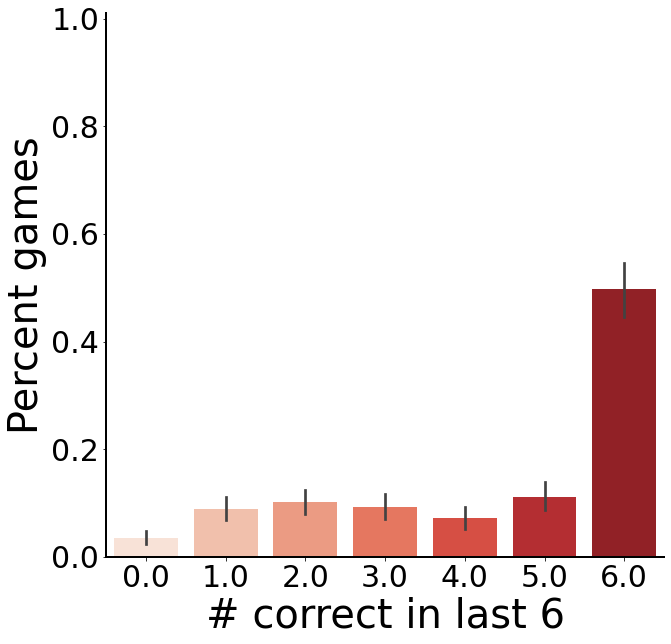

In [115]:
df_last_6 = getLastSixGames(behav_data, game_length)
fig, ax = plt.subplots(figsize=(10,10))
sns.barplot(x="Correct", y="Game", data=df_last_6, palette="Reds",ci=95);
sns.despine()
ax.set_ylim([0,1.01])
xl = ax.set_xlabel('# correct in last 6',fontsize = 40);
yl = ax.set_ylabel('Percent games',fontsize = 40);
for axis in ['top','bottom','left','right']:
      ax.spines[axis].set_linewidth(2)
ax.tick_params(labelsize=30)

# 3. Plot learning curves by age

In [100]:
# import agemap
raw_data_dir = os.getcwd().strip('ldm-analysis') + 'RawData/'
age_df = pd.read_csv(raw_data_dir + 'SubDemographics.csv').dropna()
age_df['Subj_id'] = age_df['Subj_id'].astype(int)
ageMap = age_df[['Age','Subj_id']] # .set_index('Subj_id')
ageMap

,Age,Subj_id
0,15.12,23
1,15.39,24
2,19.79,25
3,23.32,26
4,14.58,27
5,14.00,28
6,16.73,29
7,17.48,30
8,17.64,31
9,30.36,32


In [101]:
# add age related columns in behavioral dataframe
behav_data["Adult"] = False
behav_data['Age'] = np.nan
for index, row in behav_data.iterrows():
    subj_id = int(row.Subj)
    age = ageMap.loc[ageMap['Subj_id'] == subj_id].Age.item()
    if age < 10:
        behav_data.drop([index]) # remove 
        continue
    behav_data.loc[index, "Age"] = age
    if age >= 18:
        behav_data.loc[index, "Adult"] = True
behav_data

,Subj,Trial,Game,Stim11,Stim12,Stim13,Stim21,Stim22,Stim23,Stim31,...,Feat,CenterDim,CenterFeat,Correct,LearnedFeat,PoL,RT,WithinGameTrial,Adult,Age
0,23,1,1,1,6,8,2,5,7,3,...,2,NaN,NaN,1.0,NaN,NaN,1.12700,1,False,15.12
1,23,2,1,2,5,7,1,4,8,3,...,2,NaN,NaN,1.0,NaN,NaN,1.08580,2,False,15.12
2,23,3,1,3,4,7,2,5,9,1,...,2,NaN,NaN,0.0,NaN,NaN,1.24420,3,False,15.12
3,23,4,1,1,4,7,2,5,8,3,...,2,NaN,NaN,1.0,NaN,NaN,0.47509,4,False,15.12
4,23,5,1,1,6,8,2,4,7,3,...,2,NaN,NaN,1.0,NaN,NaN,0.88090,5,False,15.12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15195,71,396,20,1,5,7,3,4,9,2,...,2,NaN,NaN,1.0,NaN,NaN,0.61252,16,True,22.52
15196,71,397,20,1,5,8,2,4,9,3,...,2,NaN,NaN,1.0,NaN,NaN,0.89898,17,True,22.52
15197,71,398,20,1,6,7,2,4,9,3,...,2,NaN,NaN,1.0,NaN,NaN,0.59331,18,True,22.52
15198,71,399,20,1,6,7,3,5,8,2,...,2,NaN,NaN,1.0,NaN,NaN,0.52019,19,True,22.52


In [103]:
# split the dataframe into adult and adolescent dataframes
adult_behav_data = behav_data.loc[behav_data['Adult']]
adole_behav_data = behav_data.loc[behav_data['Adult'] == False]

## 3a. Plot age-related learning curves

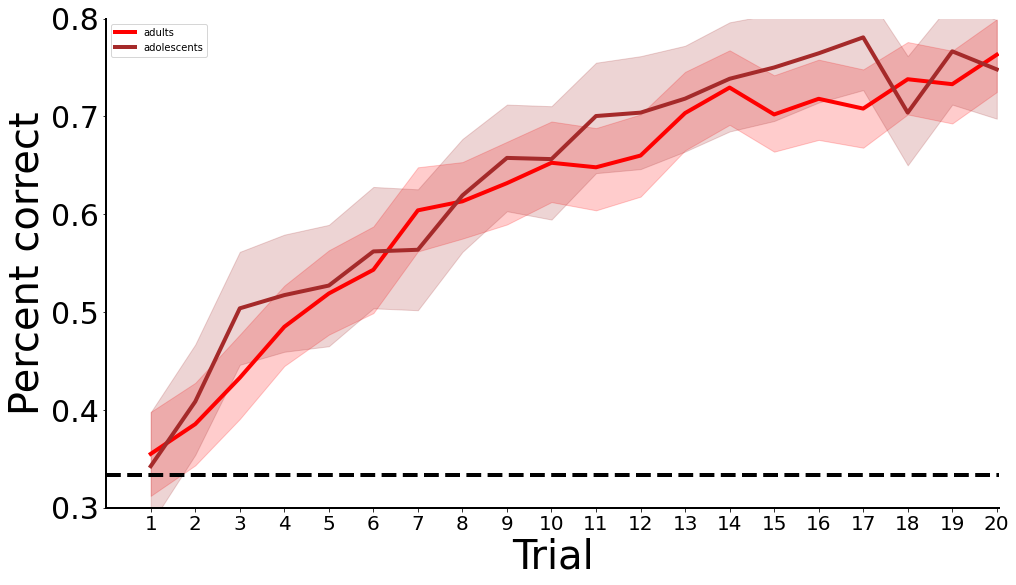

In [110]:
df_adult = pd.melt(adult_behav_data, col_level=0, id_vars='WithinGameTrial', value_vars=['Correct'])
df_adole = pd.melt(adole_behav_data, col_level=0, id_vars='WithinGameTrial', value_vars=['Correct'])

fig, ax = plt.subplots(figsize=(16,9))
ax.axhline(y=1/3, color='k', lw=4, linestyle='--');
sns.lineplot(x = 'WithinGameTrial', y="value", err_style="band", ci=95, data=df_adult, lw=4, legend='brief', label='adults', color='red')
sns.lineplot(x = 'WithinGameTrial', y="value", err_style="band", ci=95, data=df_adole, lw=4, legend='brief', label='adolescents',  color='brown')
sns.despine()
ax.set_xlim([0,game_length+.05])
ax.set_ylim([0.3,0.8])
ax.set_xticks(np.arange(game_length)+1)
xl = ax.set_xlabel('Trial',fontsize = 40);
yl = ax.set_ylabel('Percent correct',fontsize = 40);
for axis in ['top','bottom','left','right']:
      ax.spines[axis].set_linewidth(2)
ax.tick_params(axis='x',colors='k')
plt.xticks(fontsize=20);
plt.yticks(fontsize=30);

## 3b. Plot age-related number correct in last six

In [ ]:
adult_df_last_6 = getLastSixGames(adult_behav_data, game_length)
adole_df_last_6 = getLastSixGames(adole_behav_data, game_length)
fig, (ax1 = plt.subplots(figsize=(10,10))
sns.barplot(x="Correct", y="Game", data=adult_df_last_6, palette="Reds",ci=95);
sns.despine()
ax.set_ylim([0,1.01])
xl = ax.set_xlabel('# correct in last 6',fontsize = 40);
yl = ax.set_ylabel('Percent games',fontsize = 40);
for axis in ['top','bottom','left','right']:
      ax.spines[axis].set_linewidth(2)
ax.tick_params(labelsize=30)